The idea is to implement here an architecture similar to the one developed in "Datadriven wind turbine wake modeling via probabilistic Machine Learning":
- autoencoder trained on the output wake field
- MLP from input to latent space which is then plugged to the trained decoder to obtain the actual desired output

In [2]:
import torch
import torch.nn as nn
import numpy as np
import random
from math import floor, ceil

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.utils as uutils
import utils.data_utils as data_utils
import utils.plotting as plotting
from utils.evaluation import test_pytorch_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [42]:
BATCH_SIZE = 64
EPOCHS = 500
LR = 1e-2

CONSIDER_WS = False
COORDS_AS_INPUT = False # multivariate data
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cpu


In [38]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 28, 32)  # Adjust the size of the latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 4 * 4 * 28),  # Adjust the size based on the encoder
            nn.Unflatten(1, (4, 4, 28)),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, * (32, 224))
        x = torch.unsqueeze(x, 1)
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        reconstructed = reconstructed.flatten(start_dim=1)  # Remove channel dimension
        return reconstructed

### Data loading

In [6]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          #train_perc=0.6,
                                                          #test_perc=0.2,
                                                          #validation_perc=0.2,
                                                          input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader), len(test_dataloader)

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:248: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the reduction factors for the training set instead:
{'ti': 4, 'ct': 4}
  warnings.warn(


(9, 63)

In [7]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([64, 2]) torch.Size([64, 7168])
input_space=2	output_space=7168


### Autoencoder definition

In [12]:
MODEL_NAME = "prova autoencoder"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}:" +\
    f", batch size {BATCH_SIZE}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")

Model name: prova autoencoder
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01/prova autoencoder.pt
Model description: prova autoencoder_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01:, batch size 64, 500 epochs, lr=1e-06)


### Autoencoder training

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=448, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=448, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(4, 4, 28))
    (2): ReLU()
    (3): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
)
Logging prova autoencoder
Epoch 0 ->	Training loss=0.28

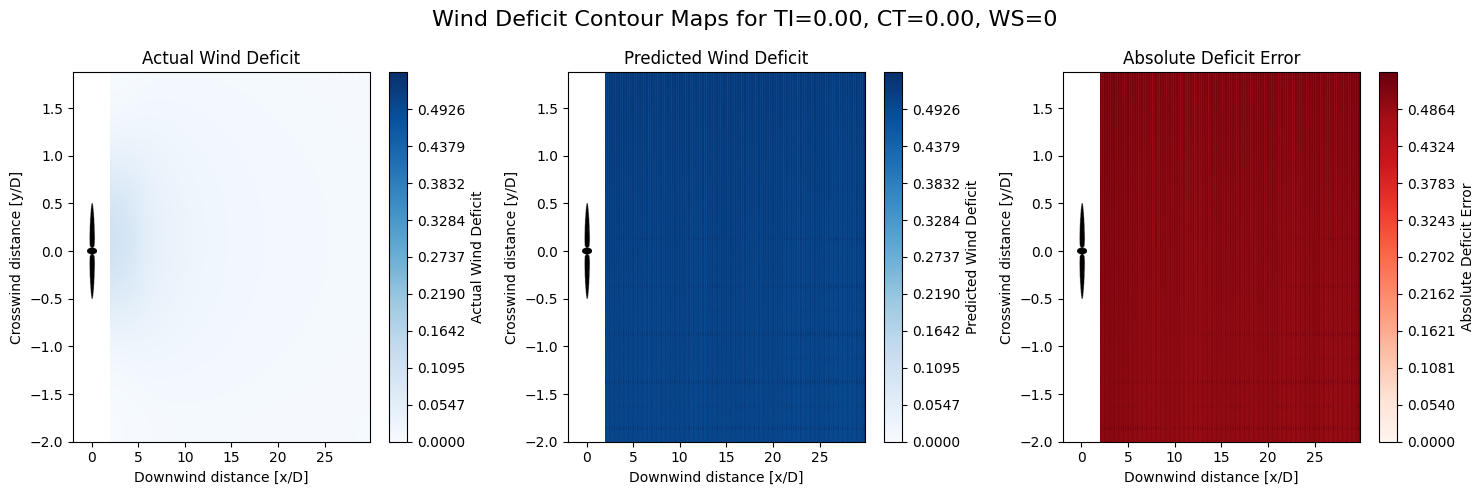

epoch_time (seconds)=34	
Epoch 1 ->	Training loss=0.1112608400258151	Validation loss=0.02144261179503447	

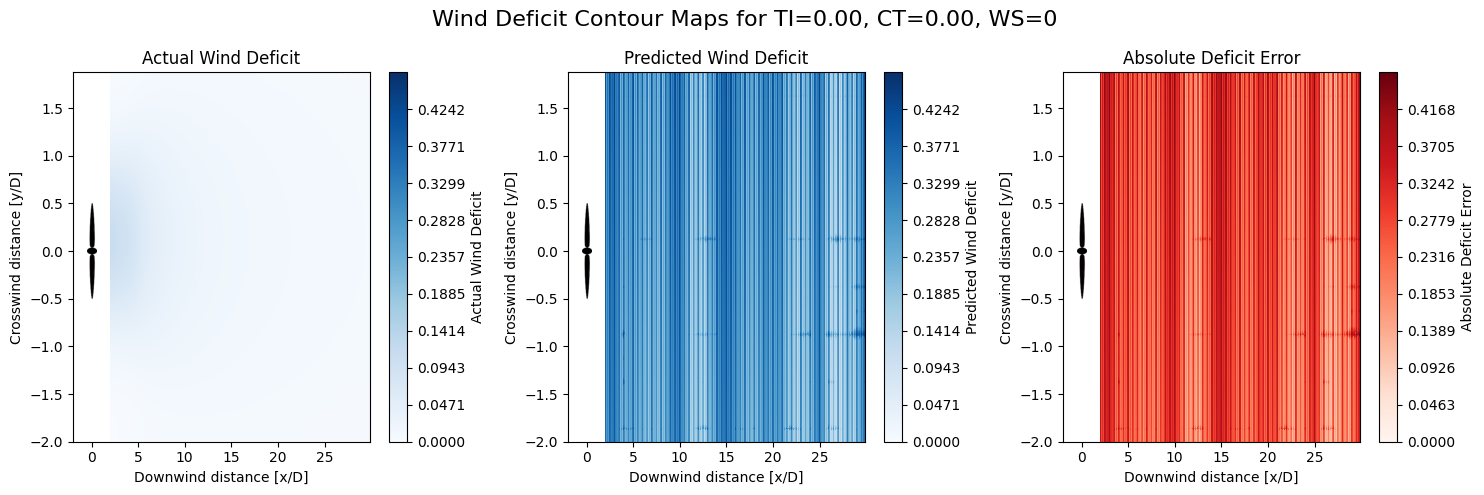

epoch_time (seconds)=61	
Epoch 2 ->	Training loss=0.008242969052358107	Validation loss=0.0018604602104758624	

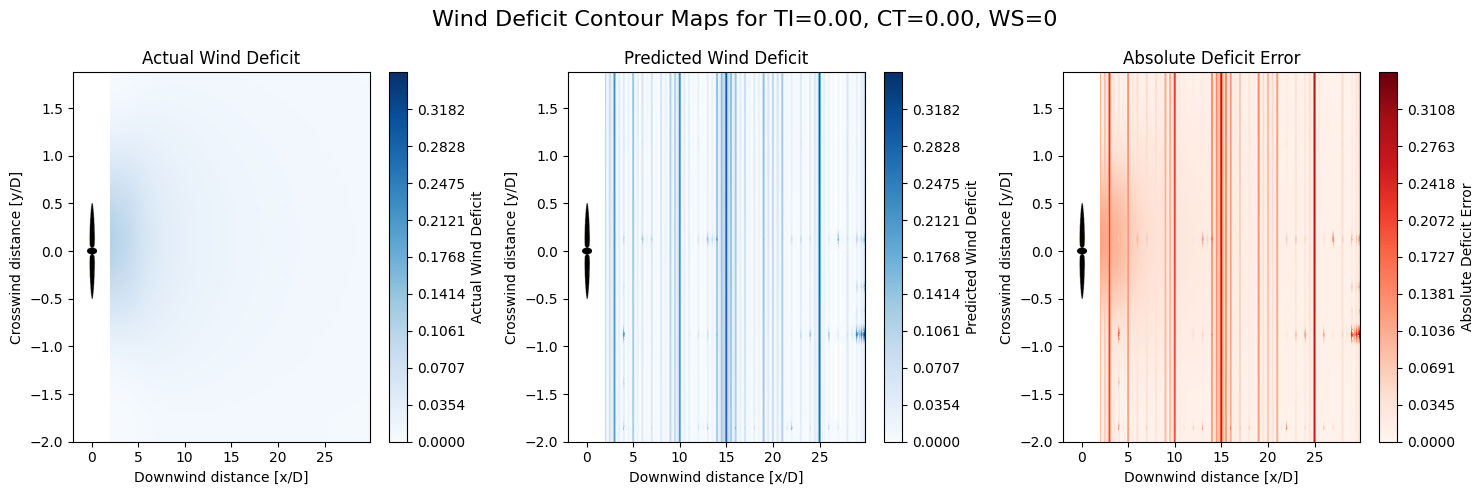

epoch_time (seconds)=24	
Epoch 3 ->	Training loss=0.001873602961952036	Validation loss=0.001488603359979132	

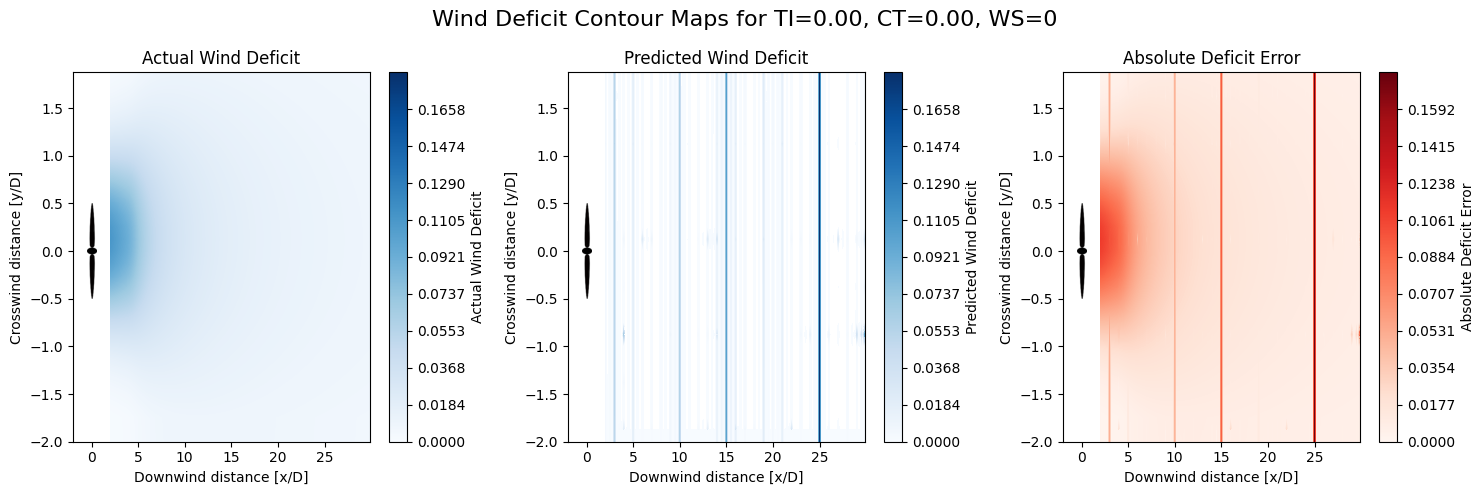

epoch_time (seconds)=9	
Epoch 4 ->	Training loss=0.0017490904439579358	Validation loss=0.0014710930498860637	

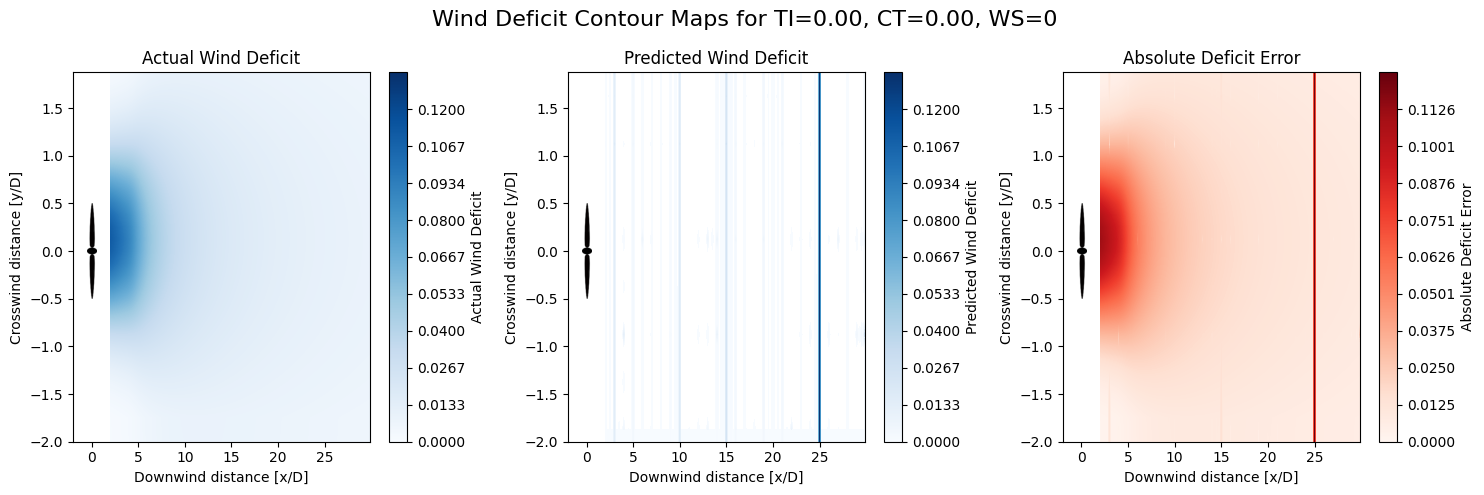

epoch_time (seconds)=8	
Epoch 5 ->	Training loss=0.0017035055295987562	Validation loss=0.0014681984021426729	

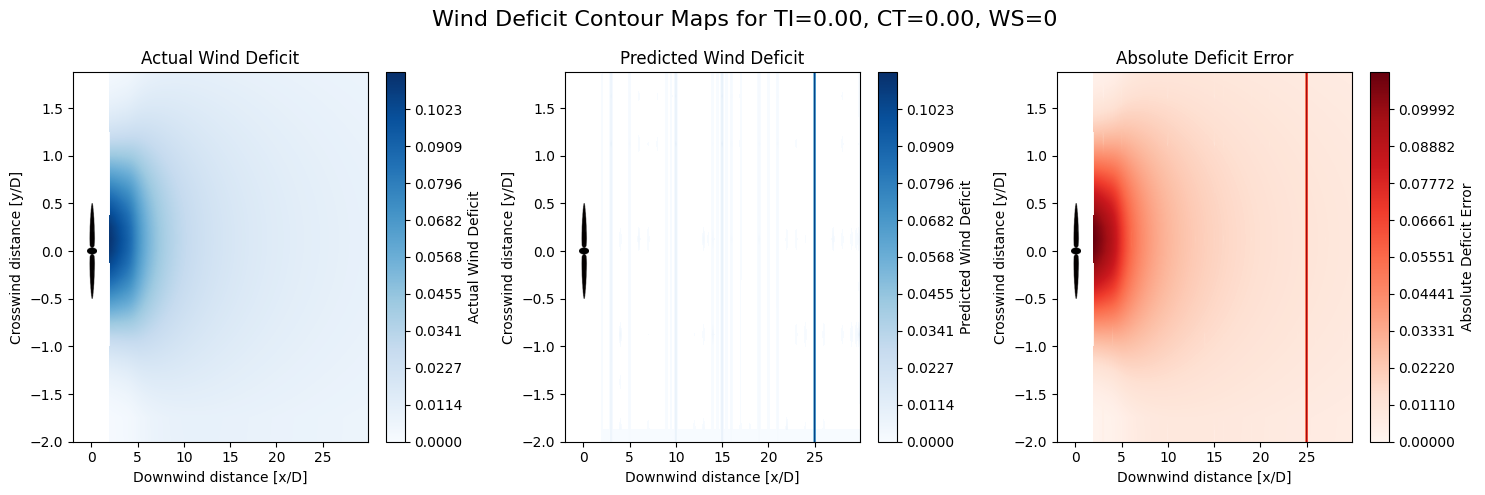

epoch_time (seconds)=8	
Epoch 6 ->	Training loss=0.001777504492889751	Validation loss=0.0014670510391085784	

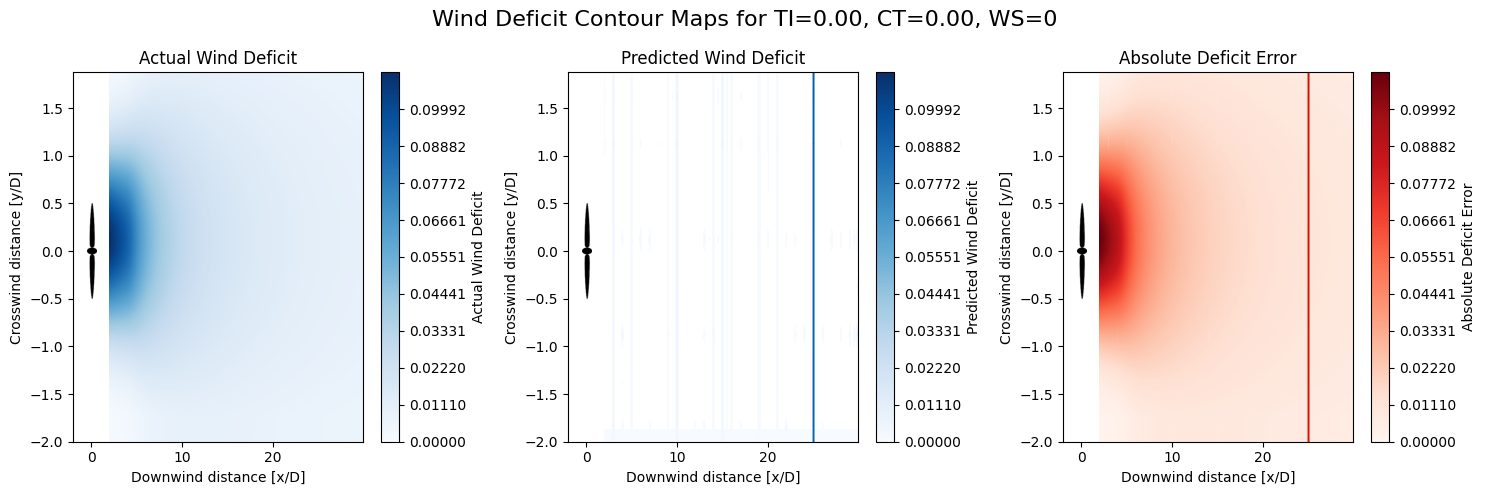

epoch_time (seconds)=7	
Epoch 7 ->	Training loss=0.0017016868564215574	Validation loss=0.0014664250061563824	

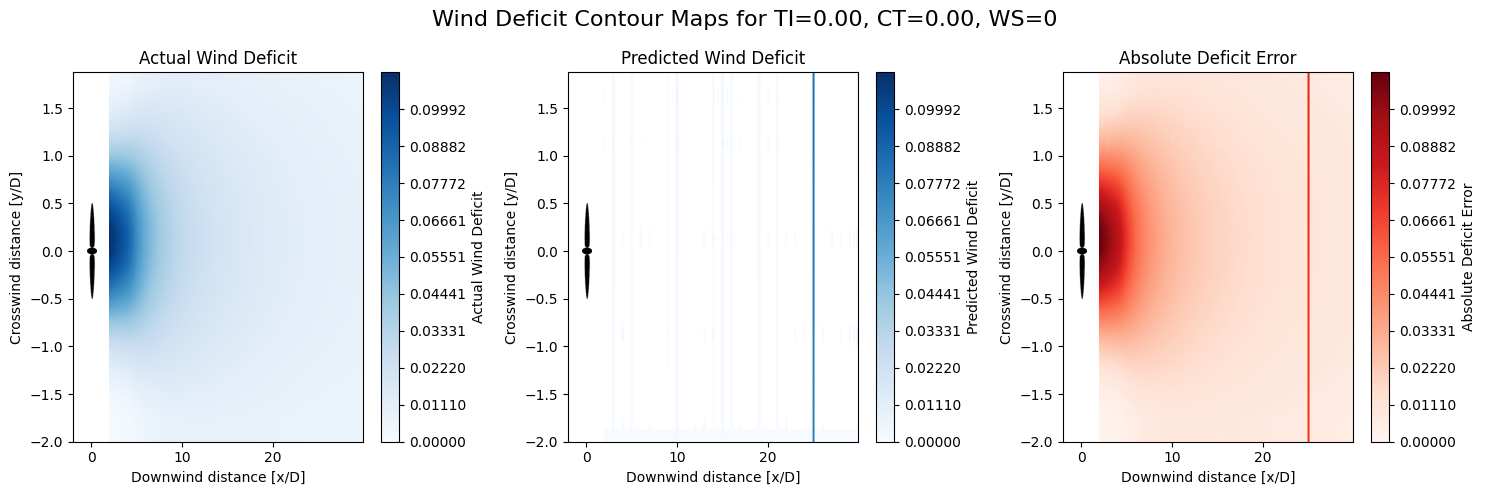

epoch_time (seconds)=8	
Epoch 8 ->	Training loss=0.0017320191318338568	Validation loss=0.0014660042320719417	

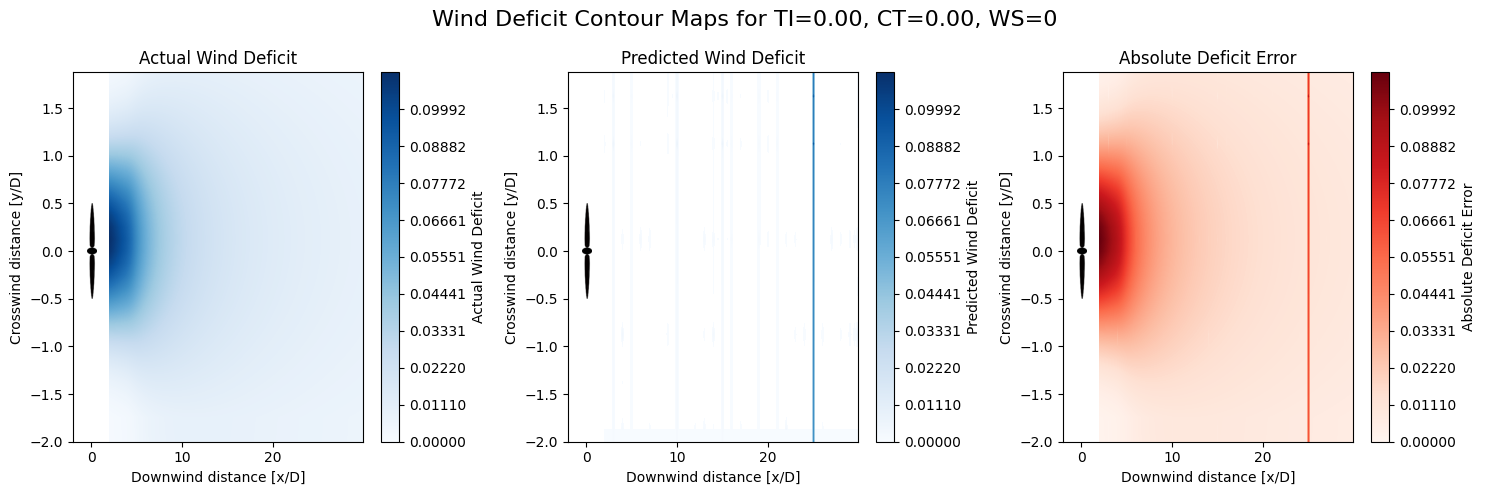

epoch_time (seconds)=13	
Epoch 9 ->	Training loss=0.0017044938084754078	Validation loss=0.0014656828612274264	

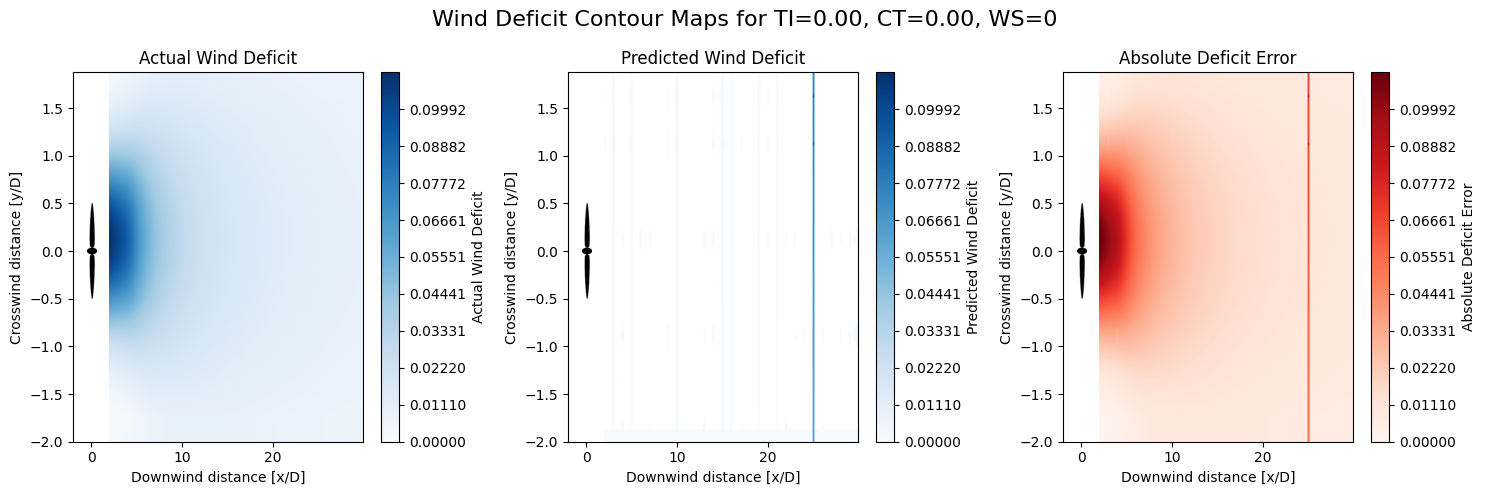

epoch_time (seconds)=15	
Epoch 10 ->	Training loss=0.0017158432440324263	Validation loss=0.0014654208432813608	

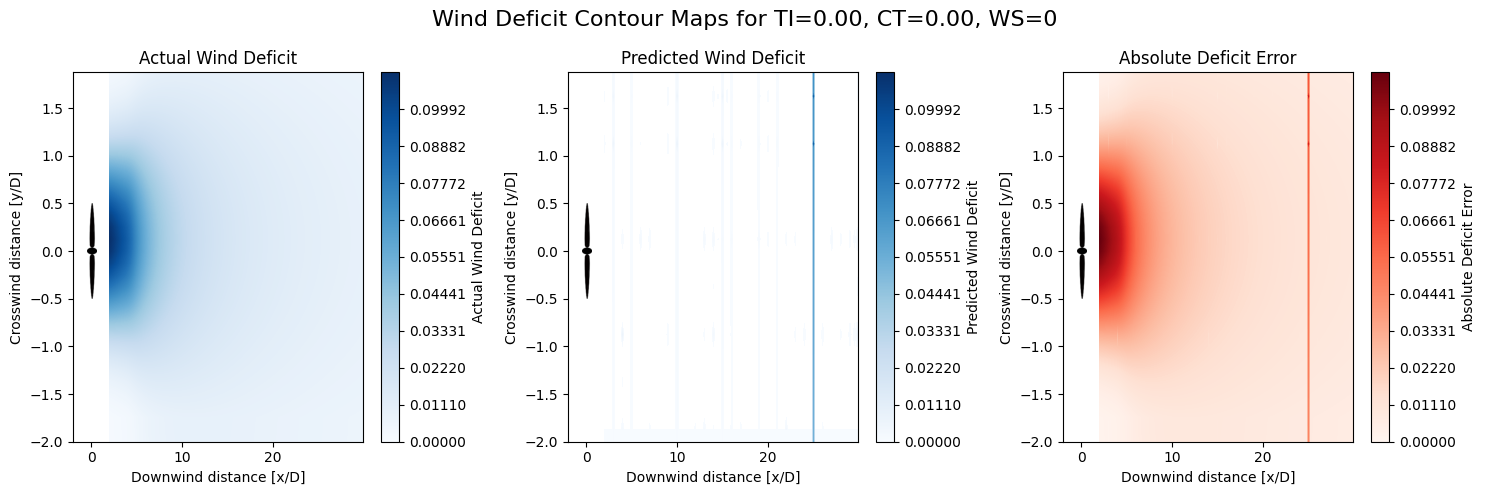

epoch_time (seconds)=10	
Epoch 11 ->	Training loss=0.0017259609292853962	Validation loss=0.0014652002501006453	

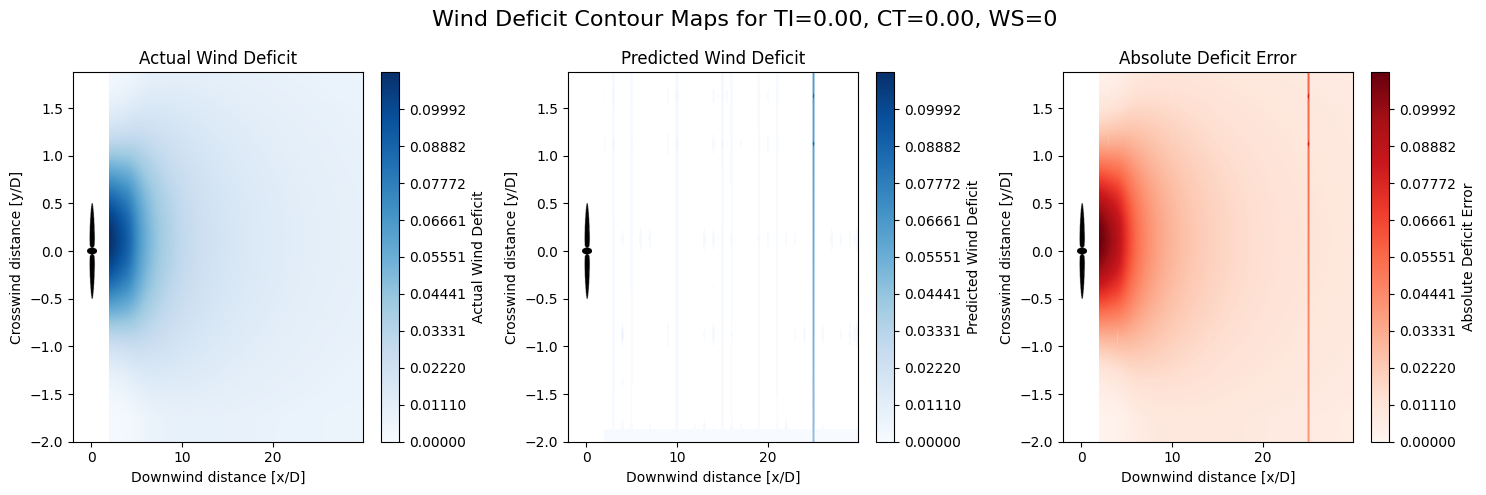

epoch_time (seconds)=14	
Epoch 12 ->	Training loss=0.0017002408883788369	Validation loss=0.0014650214477355437	

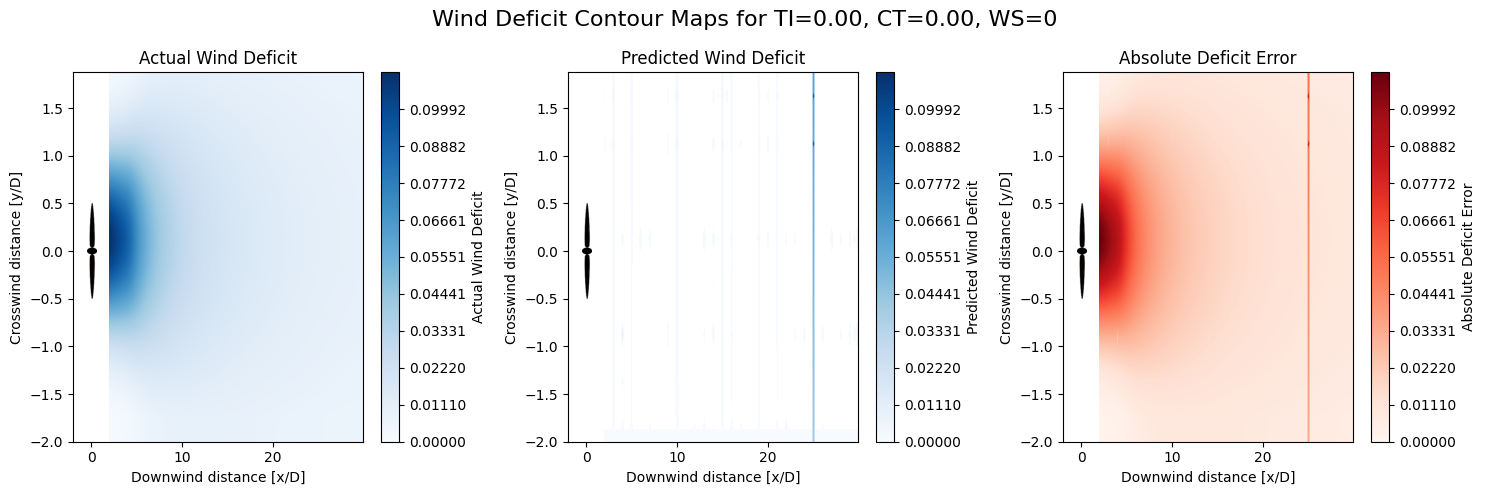

epoch_time (seconds)=11	
Epoch 13 ->	Training loss=0.0017267365753650666	Validation loss=0.0014648714916121145	

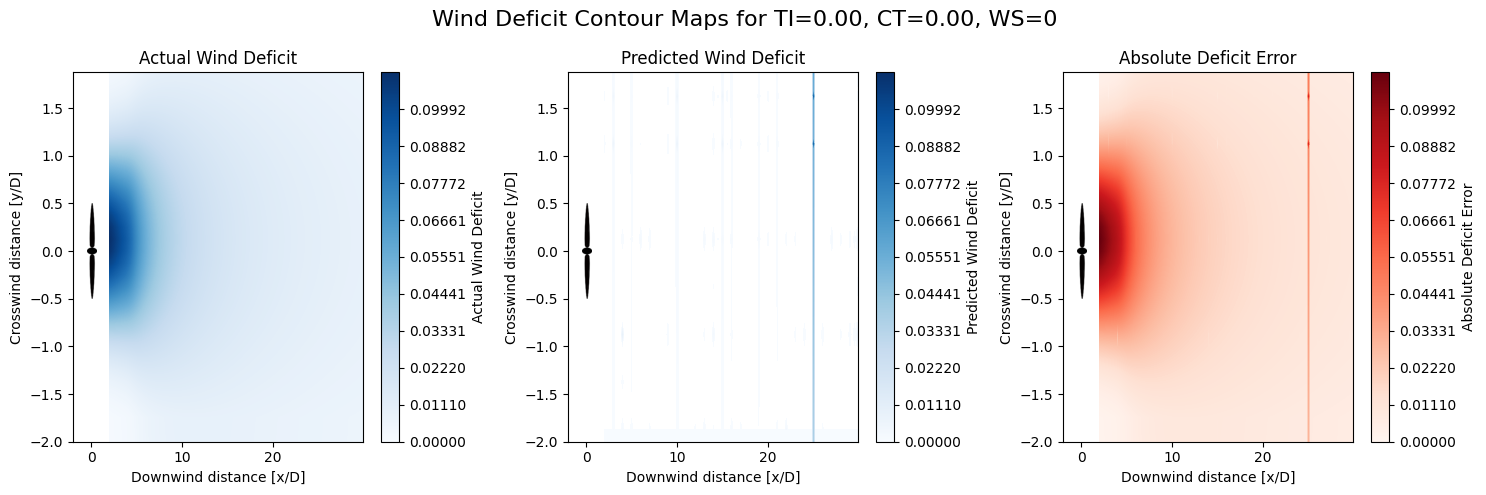

epoch_time (seconds)=13	
Epoch 14 ->	Training loss=0.001694751734083349	Validation loss=0.001464742833968275	

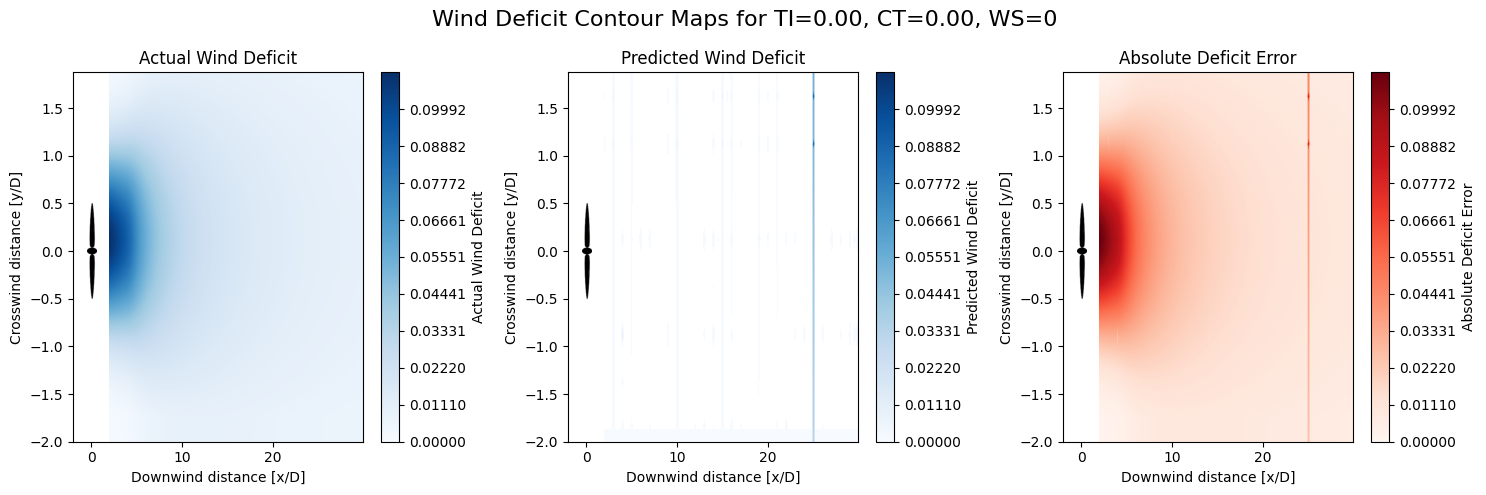

epoch_time (seconds)=11	
Epoch 15 ->	Training loss=0.001752524281089956	Validation loss=0.0014646313233034952	

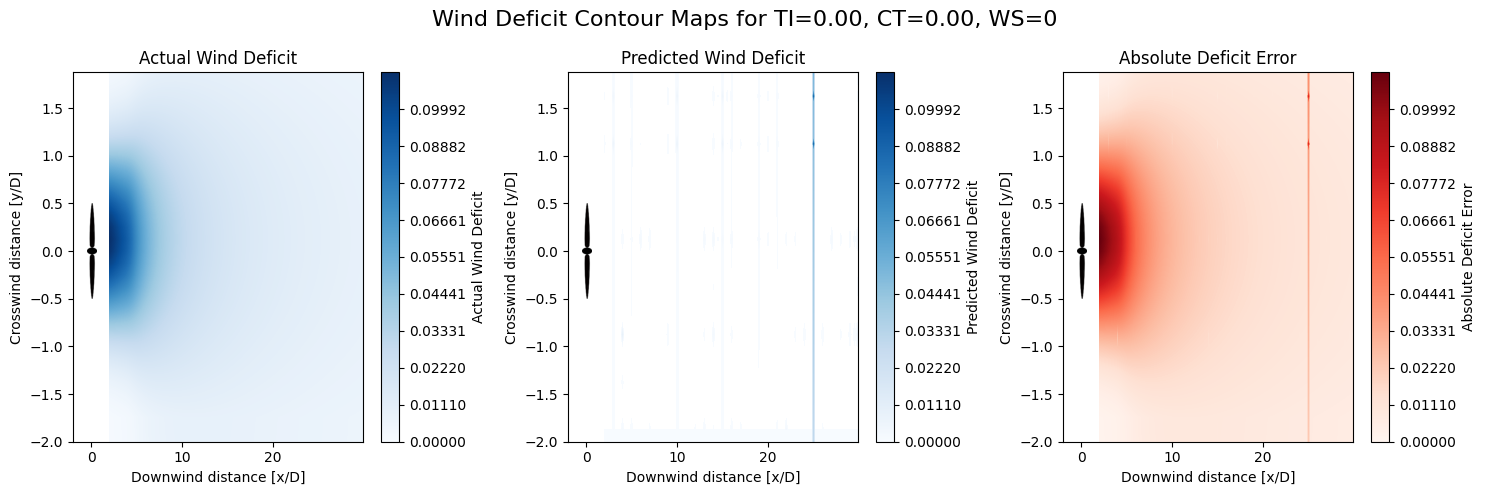

epoch_time (seconds)=9	
Epoch 16 ->	Training loss=0.0016967028514905409	Validation loss=0.0014645330533848047	

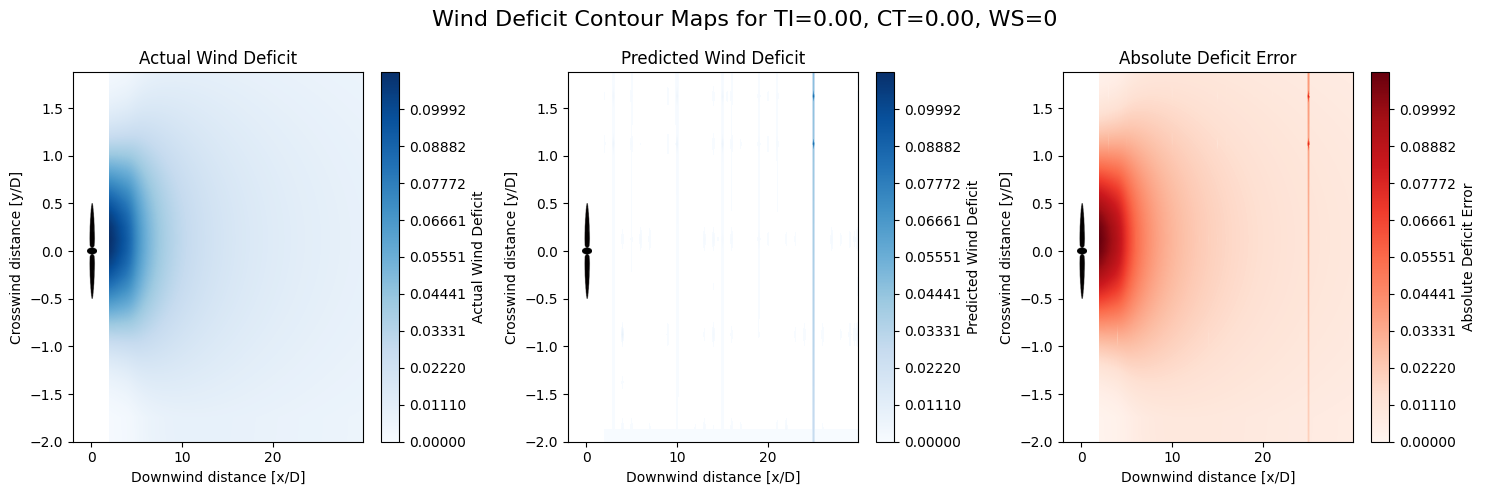

epoch_time (seconds)=10	
Epoch 17 ->	Training loss=0.001730004210363735	Validation loss=0.0014644449671603137	

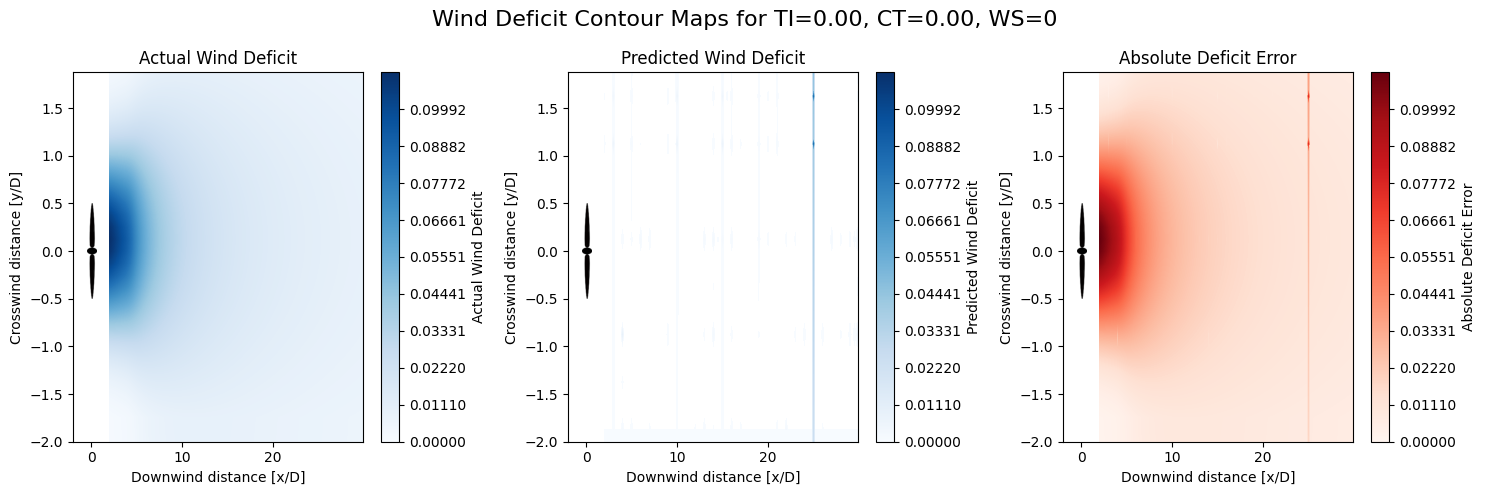

epoch_time (seconds)=15	
Epoch 18 ->	Training loss=0.0016855761476538397	Validation loss=0.0014643650358508093	

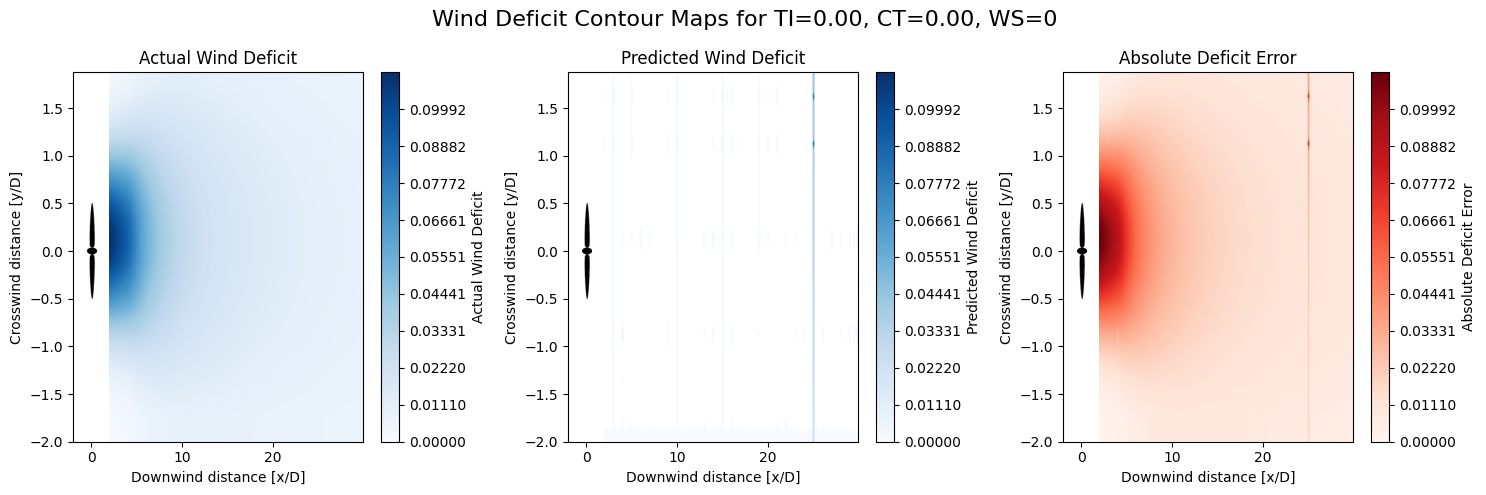

epoch_time (seconds)=10	
Epoch 19 ->	Training loss=0.001691927042874423	Validation loss=0.0014642915189821528	

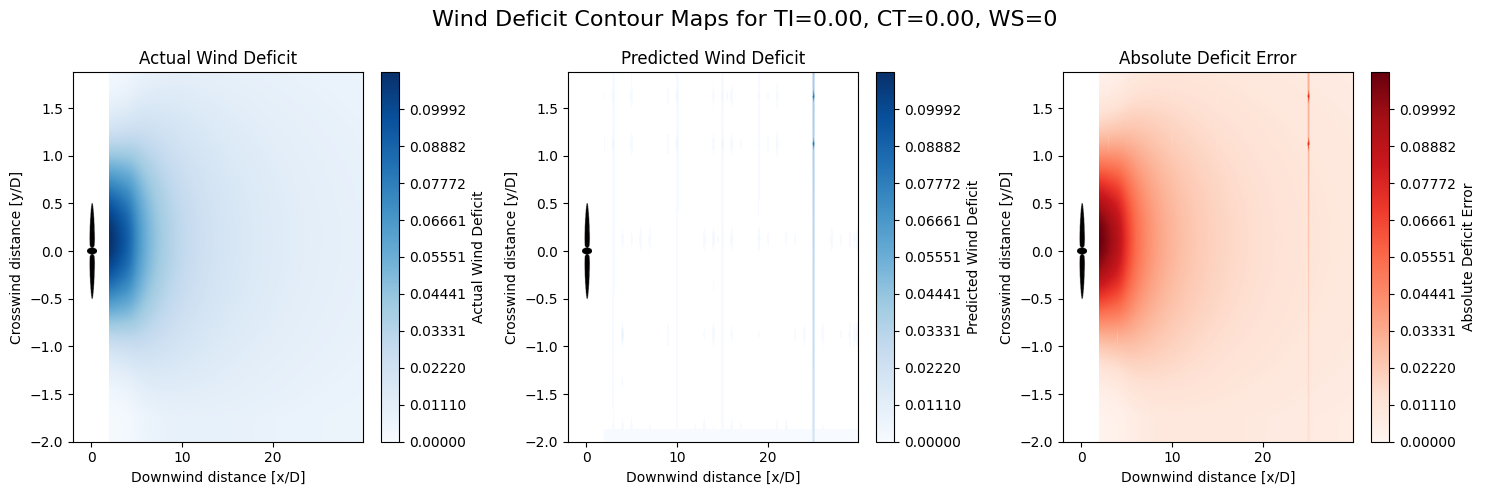

epoch_time (seconds)=11	
Epoch 20 ->	Training loss=0.0017150467363270846	Validation loss=0.001464222732075253	

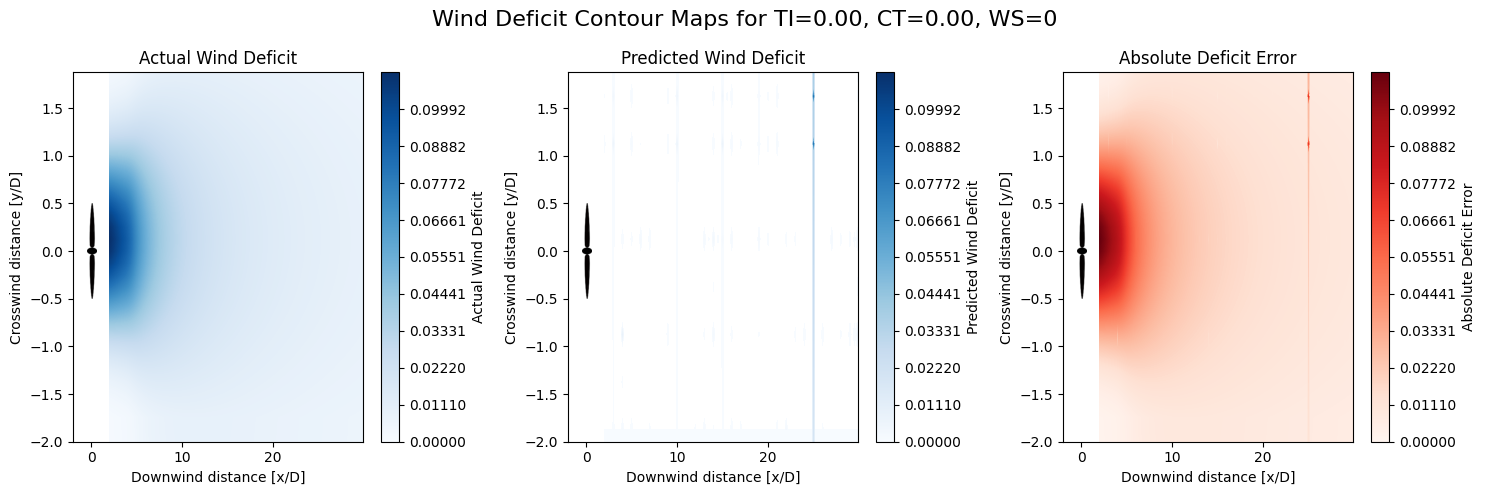

epoch_time (seconds)=11	
Epoch 21 ->	Training loss=0.0016898646544326436	Validation loss=0.0014641578379810227	

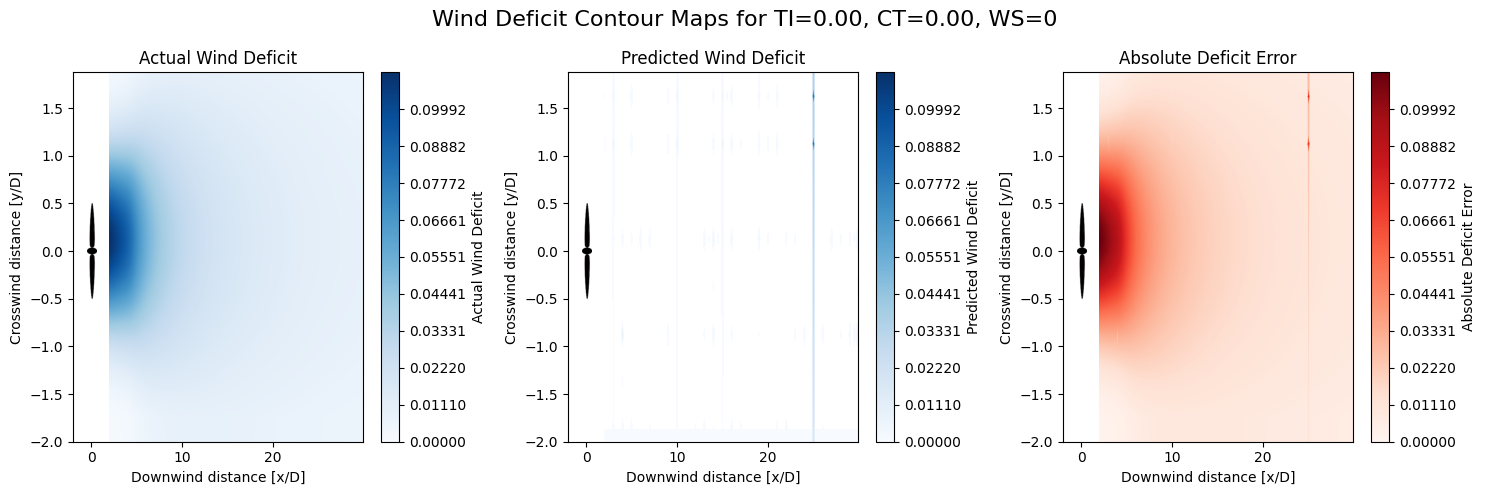

epoch_time (seconds)=18	
Epoch 22 ->	Training loss=0.0017370513623411006	Validation loss=0.0014640956510853322	

KeyboardInterrupt: 

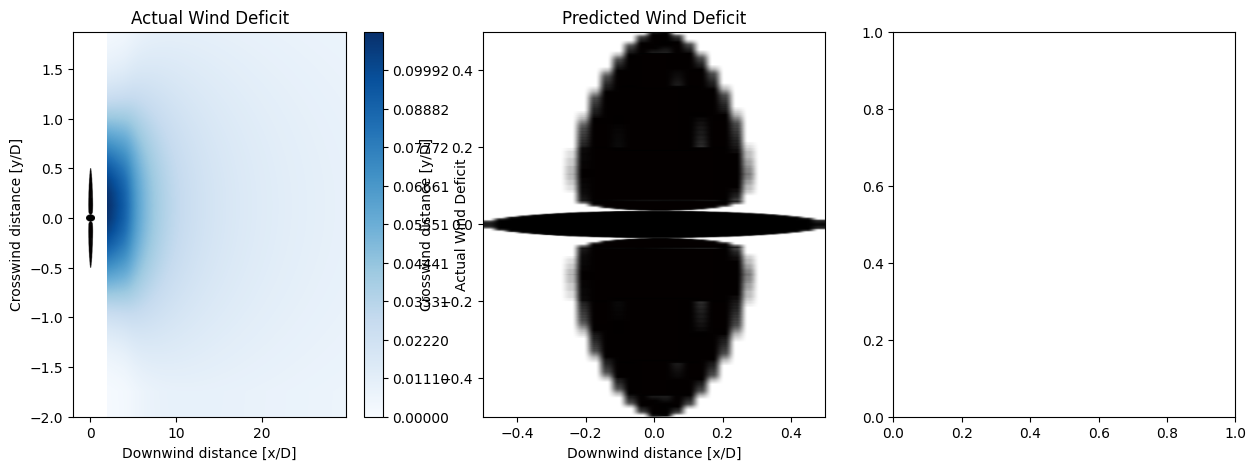

In [44]:
autoencoder = Autoencoder()
print(autoencoder)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_function = nn.MSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    autoencoder.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
        optimizer.zero_grad()
        reconstructed_wake_field = autoencoder(wake_field)
        tloss = loss_function(reconstructed_wake_field, wake_field)
        tloss.backward()
        optimizer.step()

        epoch_tloss += tloss.item() * BATCH_SIZE

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        autoencoder.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
            reconstructed_wake_field = autoencoder(wake_field)
            vloss = loss_function(reconstructed_wake_field, wake_field)

            epoch_vloss += vloss.item() * BATCH_SIZE

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(autoencoder.state_dict(), BEST_MODEL_PATH)
    
    #TODO remove from here
    rwf = reconstructed_wake_field.detach()[random.randint(0, 50)].reshape(32, 224)
    wf = wake_field.detach()[0].reshape(32, 224)
    plotting.plot_maps(train_dataloader.dataset.X_grid, train_dataloader.dataset.Y_grid,
                        wf, rwf, 0, 0, 0, error_to_plot='absolute')
    #TODO remove until here


epoch_time (seconds)=2	

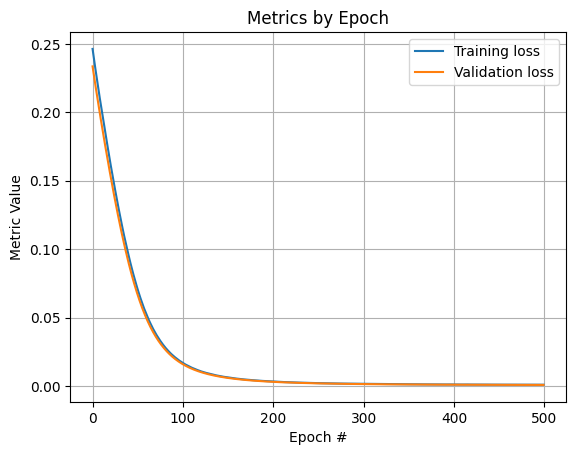

Metrics exported in the following csv file: logged_metrics/autoencoders_layers8-16-32-64-128-256-512-1024-2048-4096_training_factors=ti4-ct4_28-06-2023_18-03-27.csv


In [ ]:
metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Second part: MLP from input to latent space which is then plugged to the decoder

For the training of this second part, there are two main options:
- to calculate the loss as the final difference between the reconstructed output and the ground truth output -> it may be unfair because it would evaluate also the capacity of the decoder to reconstruct the field from the latent space
- to calculate the loss on the latent space (output of this model and the output of the previously-trained encoder) -> it may be uncorrect because it would learn from the ground truth but from a latent space that is obtained from the trained encoder

In [ ]:
# loading best autoencoder
if CONVOLUTIONAL:
    autoencoder = ConvAutoEncoder(train_dataloader.dataset.X_grid.shape).to(DEVICE)
else:
    autoencoder = AutoEncoder(HIDDEN_LAYERS_UNITS, train_dataloader.dataset.num_cells, ACTIVATION_FUNCTION).to(DEVICE)
autoencoder.load_state_dict(torch.load(BEST_MODEL_PATH))
autoencoder.eval()

bottleneck_space = min(HIDDEN_LAYERS_UNITS) # minimum of autoencoder hidden units
print(f"{bottleneck_space=}")
final_model_description = "Autoencoder description: " + MODEL_DESCRIPTION
autoencoder

bottleneck_space=8


AutoEncoder(
  (act_function): Sigmoid()
  (encoder): Sequential(
    (0): Linear(in_features=7168, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): Sigmoid()
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): Sigmoid()
    (14): Linear(in_features=64, out_features=32, bias=True)
    (15): Sigmoid()
    (16): Linear(in_features=32, out_features=16, bias=True)
    (17): Sigmoid()
    (18): Linear(in_features=16, out_features=8, bias=True)
    (19): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Sigmoid()
    (2):

In [ ]:
# new hyperparameters
HIDDEN_LAYERS_UNITS = [6, 24, 48, 16]
ACTIVATION_FUNCTION = nn.ReLU()
EPOCHS = 500
LR = 0.001

MODEL_NAME = f"aemlp_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f"(not last layer), batch size {BATCH_SIZE}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")
final_model_description += " --- MLP description: " + MODEL_DESCRIPTION

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

Model name: aemlp_layers6-24-48-16
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01/aemlp_layers6-24-48-16.pt
Model description: aemlp_layers6-24-48-16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)
DEVICE=device(type='cpu')


In [ ]:
class AE_MLP(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(AE_MLP, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = AE_MLP(input_space, bottleneck_space)

optimizer = torch.optim.Adam(
    (p for p in mlp.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss() #TODO change ?

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    mlp.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()

        bottleneck_pred = mlp.forward(input_features)
        bottleneck_truth = autoencoder.encoder(wake_field)
        
        tloss = loss_function(bottleneck_pred, bottleneck_truth)
        tloss.backward()
        optimizer.step()

        epoch_tloss += tloss.item() * BATCH_SIZE

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        mlp.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)

            bottleneck_pred = mlp.forward(input_features)
            bottleneck_truth = autoencoder.encoder(wake_field)

            vloss = loss_function(bottleneck_pred, bottleneck_truth)
            epoch_vloss += vloss.item() * BATCH_SIZE

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(mlp.state_dict(), BEST_MODEL_PATH)

Logging aemlp_layers6-24-48-16
Epoch 0 ->	Training loss=0.21512358925559305	Validation loss=0.18968148272970448	epoch_time (seconds)=1	
Epoch 1 ->	Training loss=0.18624563043767756	Validation loss=0.16421047708262568	epoch_time (seconds)=1	
Epoch 2 ->	Training loss=0.16091870394620028	Validation loss=0.14101511368840378	epoch_time (seconds)=1	
Epoch 3 ->	Training loss=0.13786941528320312	Validation loss=0.12036092118446871	epoch_time (seconds)=1	
Epoch 4 ->	Training loss=0.11594270706176758	Validation loss=0.0990473334981788	epoch_time (seconds)=1	
Epoch 5 ->	Training loss=0.09393819722262296	Validation loss=0.07872848463354644	epoch_time (seconds)=1	
Epoch 6 ->	Training loss=0.07382400339299983	Validation loss=0.060955660506064845	epoch_time (seconds)=1	
Epoch 7 ->	Training loss=0.0564080658825961	Validation loss=0.045630092976256184	epoch_time (seconds)=1	
Epoch 8 ->	Training loss=0.0414245960929177	Validation loss=0.03242992075333684	epoch_time (seconds)=1	
Epoch 9 ->	Training loss=

epoch_time (seconds)=10	

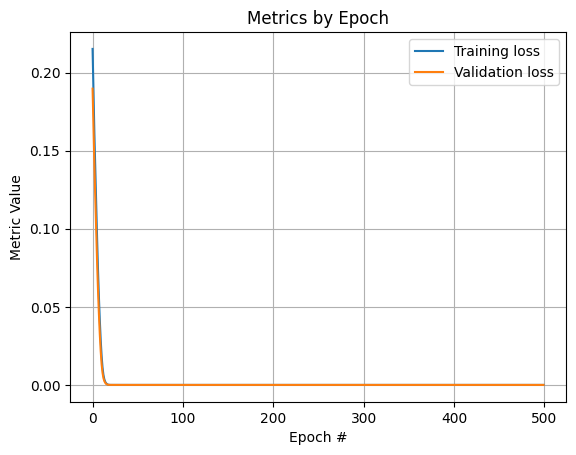

Metrics exported in the following csv file: logged_metrics/aemlp_layers6-24-48-16_28-06-2023_18-55-24.csv


In [ ]:
metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Testing

In [ ]:
# loading best mlp
mlp = AE_MLP(input_space, bottleneck_space).to(DEVICE)
mlp.load_state_dict(torch.load(BEST_MODEL_PATH))
mlp.eval()

mlp

AE_MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [ ]:
class FinalModel(nn.Module): #TODO change name
    def __init__(self, mlp: AE_MLP, autoencoder: AutoEncoder):
        super(FinalModel, self).__init__()
        self.mlp = mlp
        self.autoencoder = autoencoder

    def forward(self, x):
        x = self.mlp(x)
        x = self.autoencoder.decoder(x)
        return x


In [ ]:
# loading best model
model = FinalModel(mlp, autoencoder).to(DEVICE)
model.eval()

test_pytorch_model(model, test_dataloader,
                   model_description=final_model_description,
                   save_results=True)

Test results for Autoencoder description: autoencoders_layers8-16-32-64-128-256-512-1024-2048-4096_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. Sigmoid , batch size 64, 500 epochs, lr=1e-06) --- MLP description: aemlp_layers6-24-48-16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)
r2_score=-12.063679508094468
explained_variance_score=2.2060703486204147e-08
mean_squared_error=0.0007561064558103681
mean_absolute_error=0.017863264307379723
median_absolute_error=0.016519695520401
mean_absolute_percentage_error=1673117696000.0
Prediction time=0.00038543422770055924s


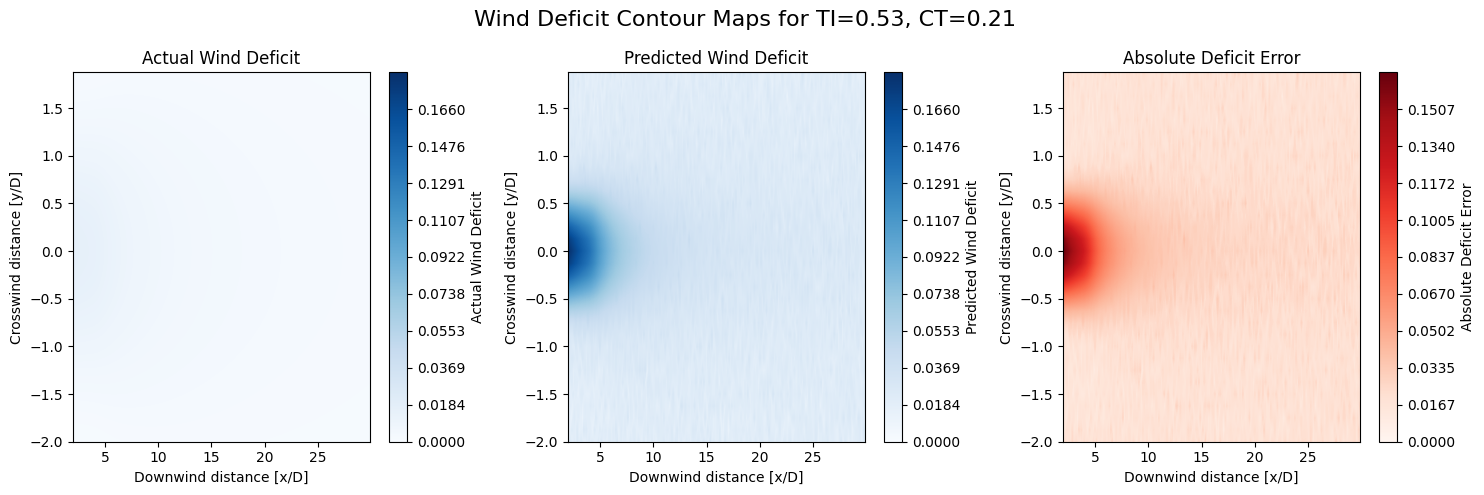

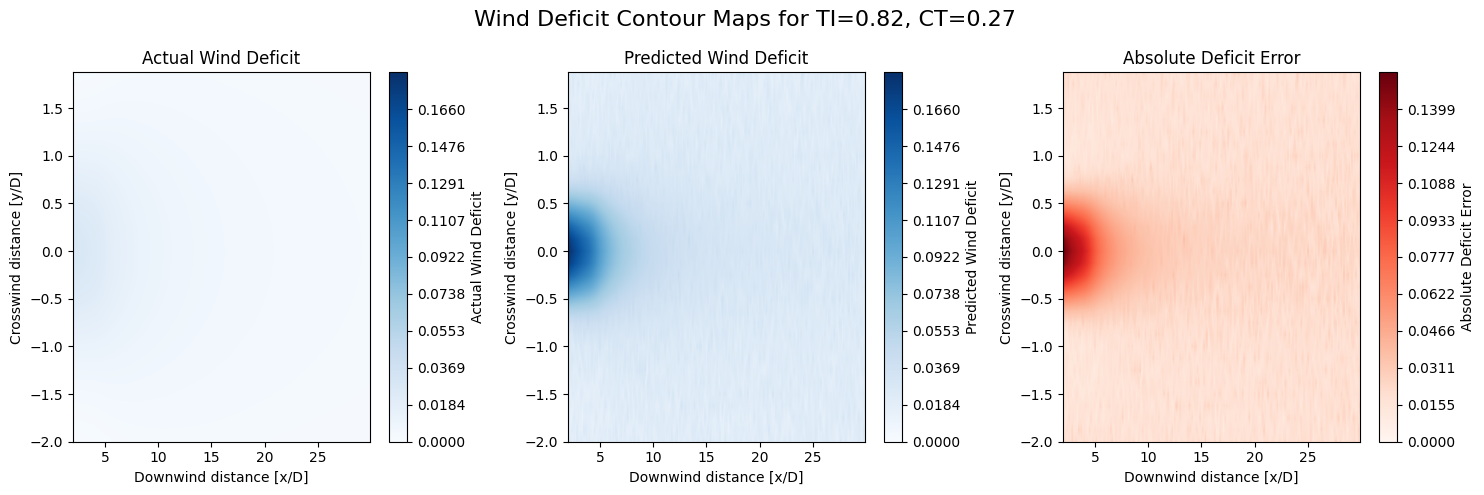

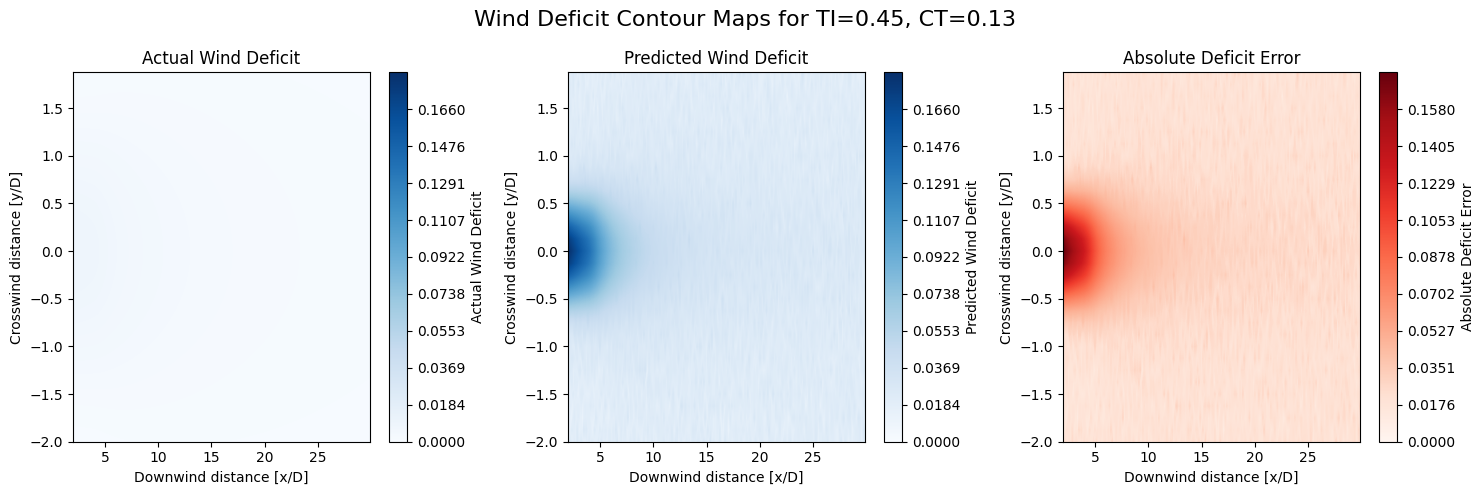

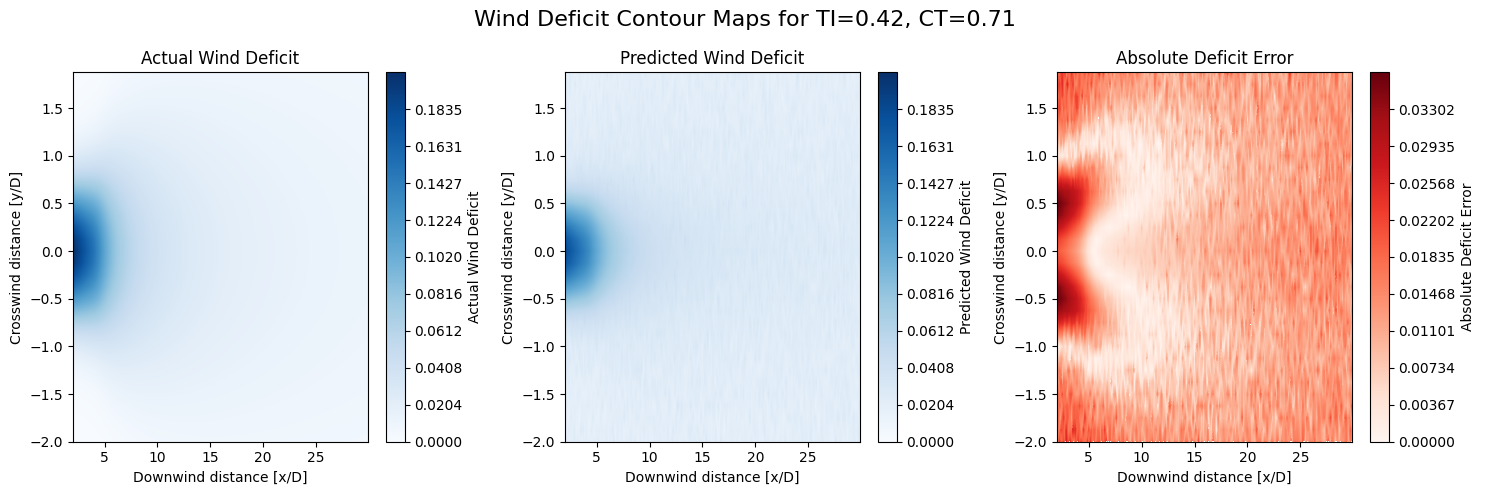

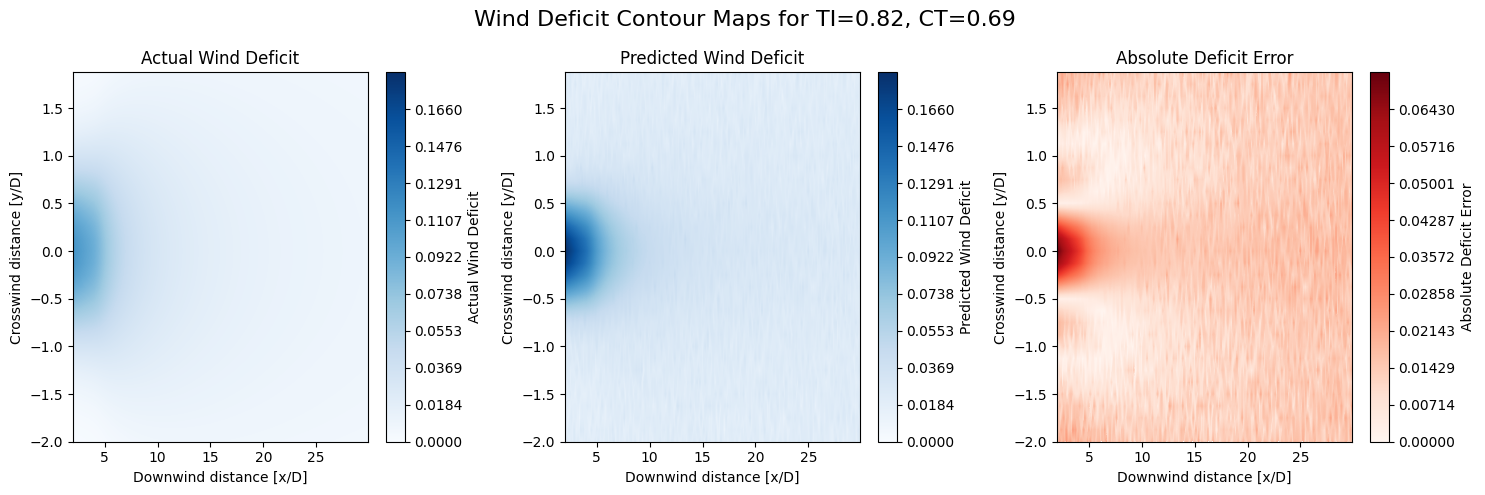

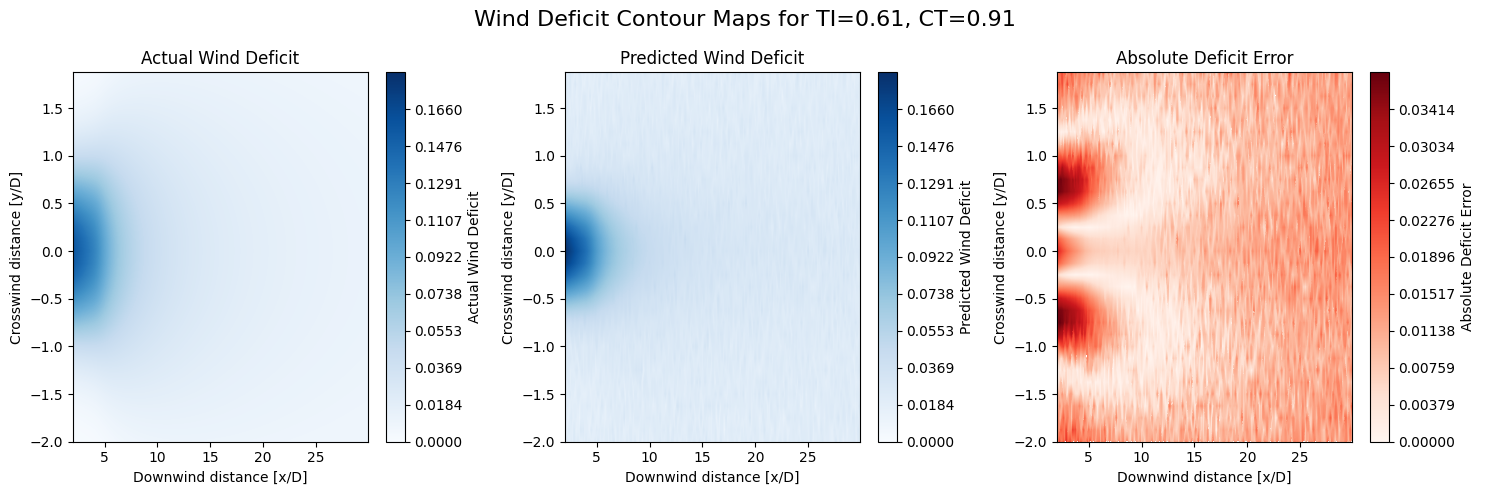

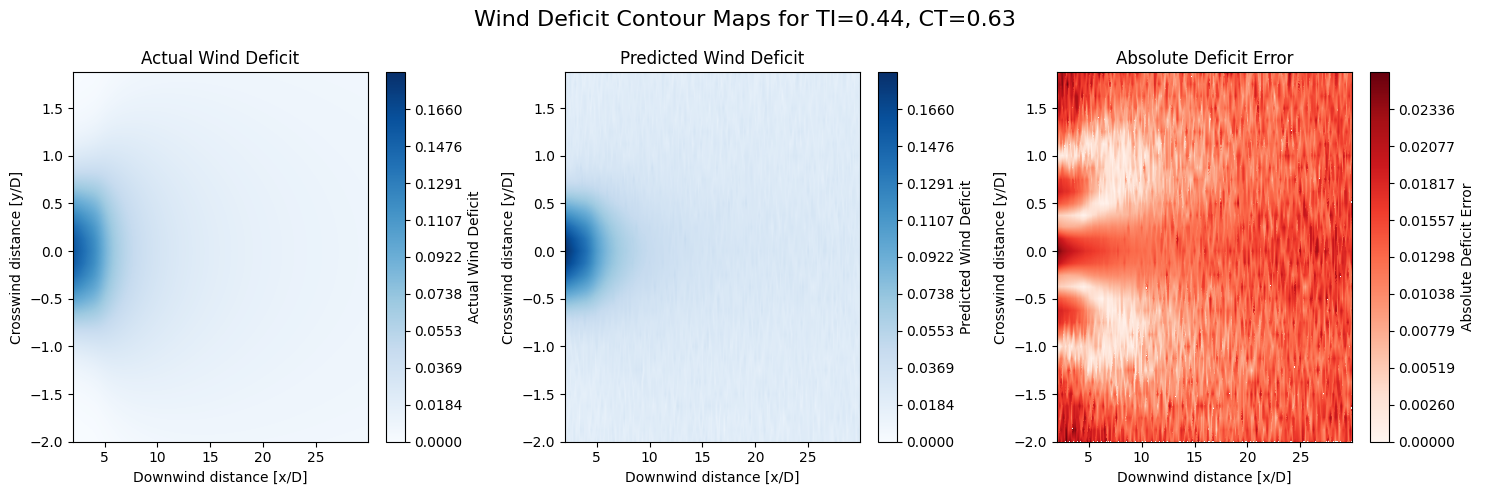

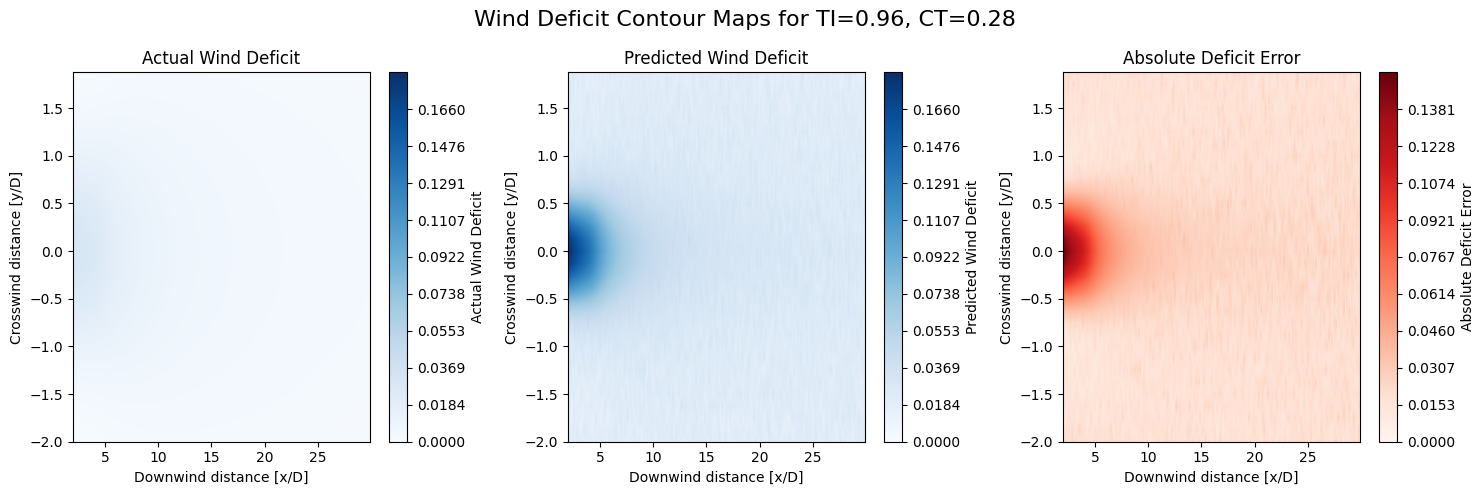

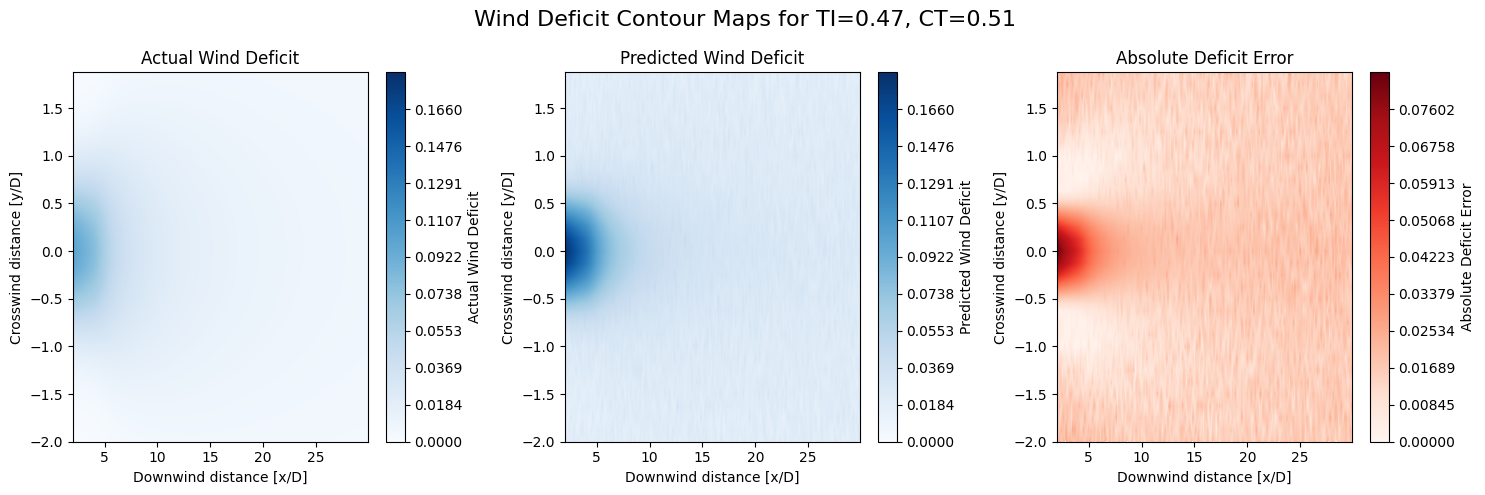

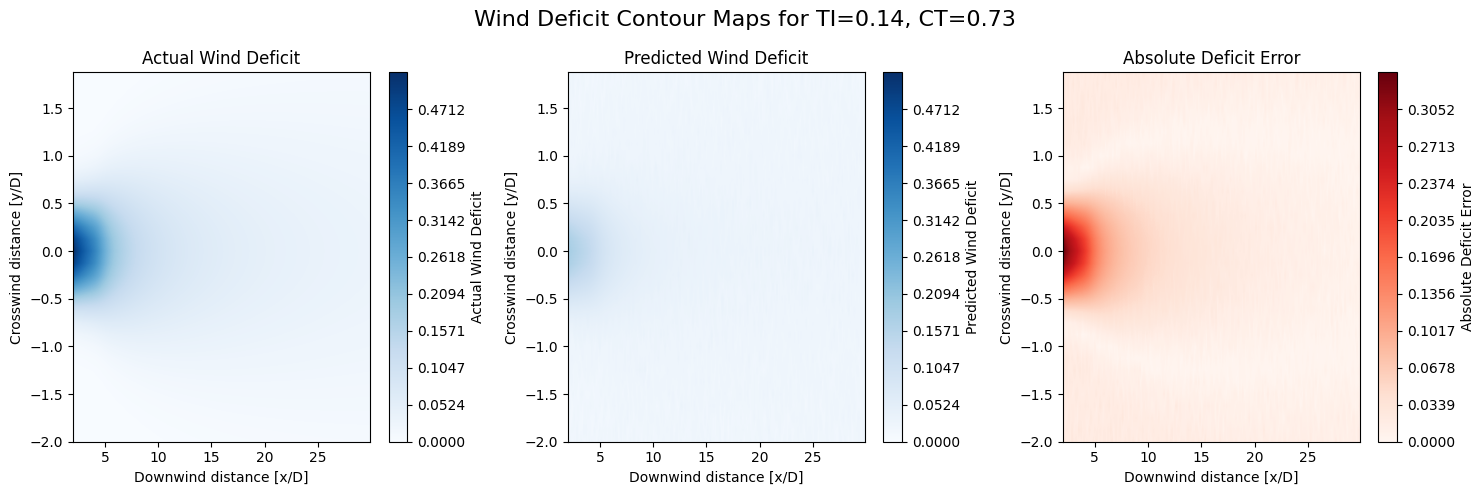

In [ ]:
test_dataset = test_dataloader.dataset
indices = list(range(len(test_dataset)))
random.shuffle(indices)
with torch.no_grad():
    for idx in indices[:10]:
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_multivariate(model, idx)
        
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')